# 1 ASSIGNMENT
# TEST : PREDICTING BAGGAGE LIKELIHOOD

## OVERVIEW
At eDreams ODIGEO we are always looking for ways to improve customer satisfaction. With this objective in mind, we would like to predict whether a new customer is interested in buying additional baggage in order to speed up the booking process.

## GOAL 
The goal of this task is to predict which new customers are going to purchase additional baggage for their trips using historical information from past bookings. The code can be developed in any of the following languages: Python, R or Java.

## DATA DESCRIPTION
Two files are attached with the training and test datasets. The training dataset contains 50,000 bookings and the test dataset 30,000 bookings. The data fields are the following ones:
* TIMESTAMP: (date) date when the booking was bought.
* WEBSITE: (string) Website where the trip was purchased. It is composed of a prefix that stands for the website (“ED” = Edreams, “OP” = Opodo, “GO” = Go Voyage) and a suffix for the country (for example: ES = Spain)
* GDS: (integer) Number of flights bought through the Global Distribution System
* NO GDS: (integer) Number of flights bought through other channels. 
* DEPARTURE: (date) Departure date
* ARRIVAL: (date) Arrival date
* ADULTS: (integer) Number of adults
* CHILDREN: (integer) Number of children
* INFANTS: (integer) Number of infants
* TRAIN: (boolean) Whether the booking contains train tickets or not
* DISTANCE: (float) Distance travelled
* DEVICE: (string) Device used for the purchase
* HAUL TYPE (string): Whether the trip was “Domestic”, “Continental” or “Intercontinental”.
* TRIP TYPE: (string) Trips can be either “One Way”, “Round Trip” or “Multi-Destination”
* PRODUCT: (string) Bookings can contain only travel (“Trip”) or travel and a hotel (“Dynpack”).
* SMS: (boolean) Indicates if the customer has selected a confirmation by SMS
* EXTRA BAGGAGE: (boolean) Variable to predict, only in the train dataset. Indicates if the customer has purchased extra baggage for the trip or not.  

## GENERAL GUIDELINES
* It is up to you to submit the solution in the format you prefer (markdown, html, jupyter notebook, shiny report, etc). Nevertheless, if the submitted files consist only in code and comments, and you plot your graphics on the side during the exploration, please include these in a folder so that they can be referenced.
* Every decision (what steps are taken, what algorithms are used, what data is transformed or discarded) should have a succinct explanation or justification.
* We are looking forward to knowing how much you know about the context (problem, possible solutions, repercussions) at every step of the data science flow. Show us the best you can do at each of the steps and why: data cleaning, transformations, validations, modeling, tuning, etc.

## EVALUATION
The evaluation will be based on the quality and explanation of the source code, analysis performed, insights extracted and comments as well as the prediction scores. For the prediction score, the metric will depend on the output: in case a binary output is submitted, the evaluation method will be the F1 Score, in case a probability is given, the evaluation method will be the AUC ROC. If you consider there is also other interesting metrics to evaluate the exercise feel free to add them.

## SUBMISSION FORMAT
The submission must contain the source code and the predictions for the 30000 bookings in CSV (Comma Separated Values) format, for instance:

    ID EXTRA_BAGGAGE
        0 True
        1 False
    [...]

Or the probabilities:
    
    ID EXTRA_BAGGAGE
        0 0.35
        1 0.78
    [...]

# 2 Dataset preprocessing
## 2.1 Load and merge datasets

In [36]:
import pandas as pd

In [37]:
train_loc = 'train (2).csv'
test_loc = 'test (1).csv'

train_pd = pd.read_csv(train_loc, index_col='ID', sep=';')
test_pd = pd.read_csv(test_loc, index_col='ID', sep=';')

train_pd['EXTRA_BAGGAGE'] = train_pd['EXTRA_BAGGAGE'].astype(int)
test_pd['EXTRA_BAGGAGE'] = 'NA'
dataset = pd.concat([train_pd, test_pd],sort=True).reset_index(drop=True)
dataset['TRAIN'] = dataset['TRAIN'].astype(int)
dataset['SMS'] = dataset['SMS'].astype(int)

### 2.1.1 Check for nonsense values

In [38]:
print('Number of rows with negative number of passangers : ' + str(len(dataset[(dataset['ADULTS'] < 0) | (dataset['INFANTS'] < 0) | (dataset['CHILDREN'] < 0)])))
print('Number of rows with 0 number of passangers : ' + str(len(dataset[(dataset['ADULTS'] == 0) & (dataset['INFANTS'] == 0) & (dataset['CHILDREN'] == 0)])))
print('Number of rows with negative number of flights : ' + str(len(dataset[(dataset['GDS'] < 0) | (dataset['NO_GDS'] < 0)])))
print('Number of rows with 0 number of flights : ' + str(len(dataset[(dataset['GDS'] == 0) & (dataset['NO_GDS'] == 0)])))

Number of rows with negative number of passangers : 0
Number of rows with 0 number of passangers : 0
Number of rows with negative number of flights : 0
Number of rows with 0 number of flights : 0


## 2.2 Time columns
### 2.2.1 Convert timestamp to datetime columns

In [39]:
dataset['TIMESTAMP'] =  pd.to_datetime(dataset['TIMESTAMP'],format='%d/%B')
dataset['DEPARTURE'] = dataset['DEPARTURE'].replace('-', '/', regex=True)
dataset['DEPARTURE'] =  pd.to_datetime(dataset['DEPARTURE'],format='%d/%B')
dataset['ARRIVAL'] = dataset['ARRIVAL'].replace('-', '/', regex=True)
dataset['ARRIVAL'] =  pd.to_datetime(dataset['ARRIVAL'],format='%d/%B')

### 2.2.2 New timestamp features
* TIME_TO_DEP - number of days between the date the flight was bought and departure (assumption - trips planned ahead have higher probability they are thouroughly planned and people will need more luggage for trip or to transport between destinations)
* TRIP_DUR - number of days between arrival and departure (assumption - people need more luggage for longer trips)

In [40]:
dataset['TIME_TO_DEP'] = (dataset['DEPARTURE'] - dataset['TIMESTAMP']).astype('timedelta64[D]').astype(int)
dataset['TRIP_DUR'] = (dataset['ARRIVAL'] - dataset['DEPARTURE']).astype('timedelta64[D]').astype(int)

#### 2.2.2.1 Check for nonsese values

In [41]:
print('Number of rows with one-way trips that have duration > 0 : ' + str(len(dataset[(dataset['TRIP_TYPE']=='ONE_WAY') & (dataset['TRIP_DUR']>0)])))
print('Number of rows with negative trip duration : ' + str(len(dataset[dataset['TRIP_DUR']<0])))
print('Number of rows with negative time to departure : ' + str(len(dataset[dataset['TIME_TO_DEP']<0])))

dataset = dataset[~((dataset['TRIP_TYPE']=='ONE_WAY') & (dataset['TRIP_DUR']>0))]
dataset = dataset[~(dataset['TRIP_DUR']<0)]
dataset = dataset[~(dataset['TIME_TO_DEP']<0)]

Number of rows with one-way trips that have duration > 0 : 388
Number of rows with negative trip duration : 819
Number of rows with negative time to departure : 1002


## 2.3 One hot encoding of categorical columns
* one hot encoding of selected columns ['DEVICE', 'HAUL_TYPE', 'PRODUCT', 'TRIP_TYPE', 'WEBSITE']

In [42]:
dataset = pd.get_dummies(dataset, columns=['DEVICE', 'HAUL_TYPE', 'PRODUCT', 'TRIP_TYPE', 'WEBSITE'])

## 2.4 Clear dataset from columns we will not use

In [43]:
dataset.drop(columns=['ARRIVAL','DEPARTURE','DISTANCE','TIMESTAMP','TRIP_TYPE_ONE_WAY'], inplace=True)
dataset.to_csv('dataset.csv', index=False)
dataset.head()

,ADULTS,CHILDREN,EXTRA_BAGGAGE,GDS,INFANTS,NO_GDS,SMS,TRAIN,TIME_TO_DEP,TRIP_DUR,...,WEBSITE_OPIT,WEBSITE_OPNL,WEBSITE_OPPL,WEBSITE_OPPLC,WEBSITE_OPUK,WEBSITE_TLDK,WEBSITE_TLDKC,WEBSITE_TLFI,WEBSITE_TLNO,WEBSITE_TLSE
0,1,0,0,1,0,0,1,0,21,3,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,28,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,2,0,0,1,0,28,21,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,2,0,0,23,11,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,41,0,...,0,0,0,0,0,0,0,0,0,0


## 2.5 Feature selection - feature correlation

In [45]:
dataset.dtypes

ADULTS            int64
CHILDREN          int64
EXTRA_BAGGAGE    object
GDS               int64
INFANTS           int64
                  ...  
WEBSITE_TLDK      uint8
WEBSITE_TLDKC     uint8
WEBSITE_TLFI      uint8
WEBSITE_TLNO      uint8
WEBSITE_TLSE      uint8
Length: 81, dtype: object

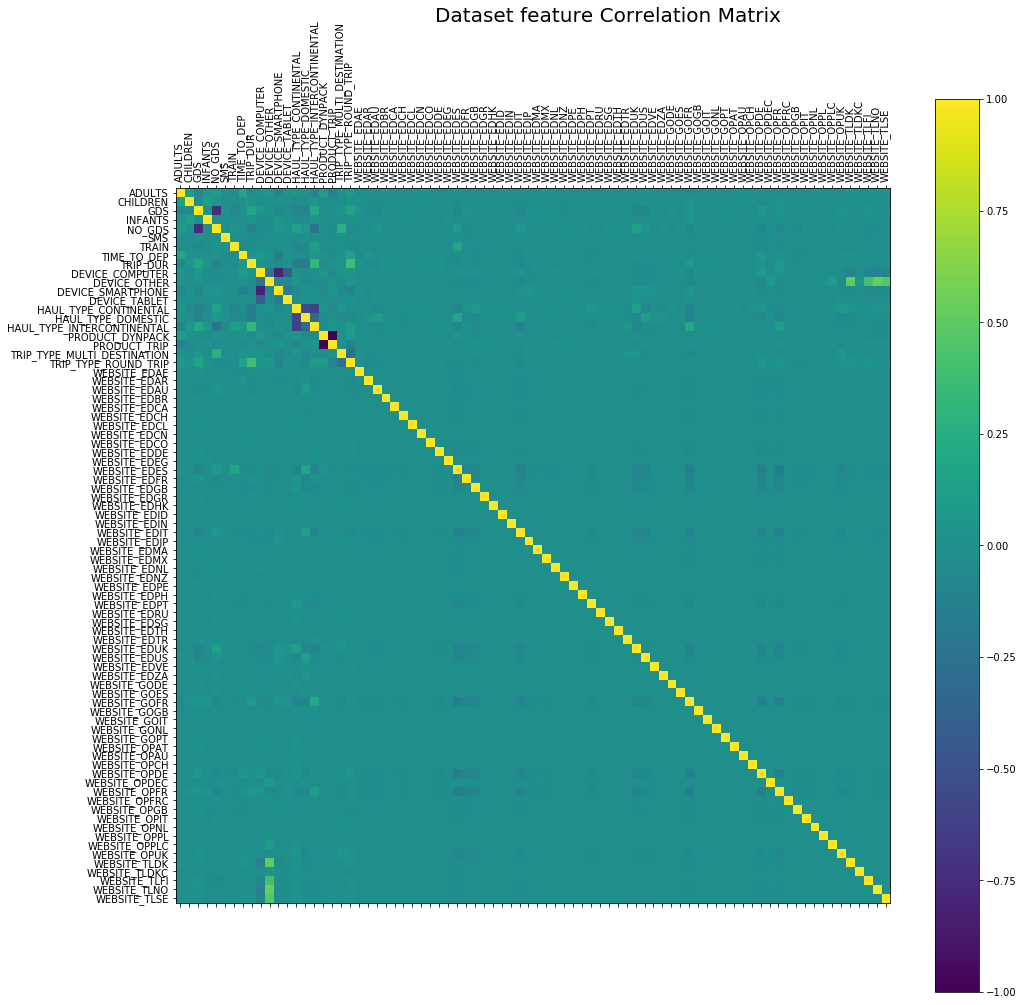

In [48]:
dataset_corr = dataset[~dataset['EXTRA_BAGGAGE'].isnull()].drop(columns=['EXTRA_BAGGAGE']).corr()

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
fig.suptitle('Dataset feature Correlation Matrix', size=20)

heatmap = ax.matshow(dataset_corr)
ax.set_xticks(range(dataset.drop(columns=['EXTRA_BAGGAGE']).shape[1]))
ax.set_xticklabels(dataset.drop(columns=['EXTRA_BAGGAGE']).columns, fontsize=10, rotation=90)
ax.set_yticks(range(dataset.drop(columns=['EXTRA_BAGGAGE']).shape[1]))
ax.set_yticklabels(dataset.drop(columns=['EXTRA_BAGGAGE']).columns, fontsize=10)
cb = fig.colorbar(heatmap)
cb.ax.tick_params(labelsize=10)
plt.subplots_adjust(top=0.90)

# 3 Algorithms evaluation

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# https://xgboost.readthedocs.io/en/latest/
import xgboost
from sklearn.model_selection import GridSearchCV 
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
# defining scoring strategy:
# https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions
# scoring needs to be changed with string, ie : LogisticRegressionCV(cv=10, random_state=0 scoring="f1_score").fit(samples, labels)
# https://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import cross_val_score

## 3.1 Evaluation dataset

In [54]:
dataset_loc = 'dataset.csv'
dataset = pd.read_csv(dataset_loc, index_col=False)

### 3.1.1 Check if dataset is unbalanced

In [56]:
print('Fraction of train dataset with EXTRA BAGGAGE : ' + str(len(dataset[dataset['EXTRA_BAGGAGE']==1])/len(dataset[~dataset['EXTRA_BAGGAGE'].isnull()])))
print('Fraction of train dataset with EXTRA BAGGAGE : ' + str(len(dataset[dataset['EXTRA_BAGGAGE']==0])/len(dataset[~dataset['EXTRA_BAGGAGE'].isnull()])))
print('Size of test dataset without EXTRA BAGGAGE label : ' + str(len(dataset[dataset['EXTRA_BAGGAGE'].isnull()])))

Fraction of train dataset with EXTRA BAGGAGE : 0.19751437962202137
Fraction of train dataset with EXTRA BAGGAGE : 0.8024856203779787
Size of test dataset without EXTRA BAGGAGE label : 29123


#### 3.1.1.1 Simple random Under sampling solution

In [57]:
dataset_class_1 = dataset[dataset['EXTRA_BAGGAGE'] == 1]
dataset_class_0 = dataset[dataset['EXTRA_BAGGAGE'] == 0]
dataset_test = dataset[dataset['EXTRA_BAGGAGE'].isnull()]

dataset_class_0_under = dataset_class_0.sample(len(dataset_class_1))
dataset_under = pd.concat([dataset_class_0_under, dataset_class_1, dataset_test]).reset_index(drop=True)

#### 3.1.1.2 Simple random Over sampling solution

In [58]:
dataset_class_1 = dataset[dataset['EXTRA_BAGGAGE'] == 1]
dataset_class_0 = dataset[dataset['EXTRA_BAGGAGE'] == 0]
dataset_test = dataset[dataset['EXTRA_BAGGAGE'].isnull()]

dataset_class_1_over = dataset_class_1.sample(len(dataset_class_0), replace=True)
dataset_over = pd.concat([dataset_class_1_over, dataset_class_0, dataset_test]).reset_index(drop=True)

### 3.1.2 Scaling
* scale non binary columns using Standard Scaler

In [71]:
non_binary_cols = ['ADULTS','CHILDREN','GDS','INFANTS','NO_GDS','TIME_TO_DEP','TRIP_DUR']

scaler = StandardScaler()
dataset_under_transformed = pd.DataFrame(scaler.fit_transform(dataset_under[non_binary_cols]), columns=non_binary_cols)
dataset_under_transformed = pd.concat([dataset_under_transformed, dataset_under.drop(columns=non_binary_cols)], axis=1)

dataset_over_transformed = pd.DataFrame(scaler.fit_transform(dataset_over[non_binary_cols]), columns=non_binary_cols)
dataset_over_transformed = pd.concat([dataset_over_transformed, dataset_over.drop(columns=non_binary_cols)], axis=1)

### 3.1.3 Prepare train-datasets for evaluation

In [72]:
eval_samples_under = dataset_under_transformed[~dataset_under_transformed['EXTRA_BAGGAGE'].isnull()].drop(columns=['EXTRA_BAGGAGE']).values
eval_labels_under = dataset_under[~dataset_under['EXTRA_BAGGAGE'].isnull()]['EXTRA_BAGGAGE'].values
eval_samples_train_under, eval_samples_test_under, eval_labels_train_under, eval_labels_test_under = train_test_split(eval_samples_under, eval_labels_under, test_size=0.1)

eval_samples_over = dataset_over_transformed[~dataset_over_transformed['EXTRA_BAGGAGE'].isnull()].drop(columns=['EXTRA_BAGGAGE']).values
eval_labels_over = dataset_over[~dataset_over['EXTRA_BAGGAGE'].isnull()]['EXTRA_BAGGAGE'].values
eval_samples_train_over, eval_samples_test_over, eval_labels_train_over, eval_labels_test_over = train_test_split(eval_samples_over, eval_labels_over, test_size=0.1)

# 3.1 Logistic regression

### 3.1.1 Under sampled dataset

In [19]:
LR_clf = LogisticRegression(solver='lbfgs')
LRscores = cross_val_score(LR_clf, eval_samples_under, eval_labels_under, cv=10, scoring='f1_weighted')
LR_clf.fit(eval_samples_train_under, eval_labels_train_under)
LR_predicted = LR_clf.predict(eval_samples_test_under)
print('LR 10CV f1_weighted scores : ' + str(LRscores))
print('LR classification report :\n' + str(classification_report(eval_labels_test_under, LR_predicted)))
print('LR confusion matrix :\n' + str(confusion_matrix(eval_labels_test_under, LR_predicted)))

/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

LR 10CV f1_weighted scores : [0.64509129 0.63678484 0.6503503  0.63649013 0.64463552 0.6527918
 0.6507088  0.65244001 0.65762614 0.66194022]
LR classification report :
              precision    recall  f1-score   support

         0.0       0.63      0.63      0.63       944
         1.0       0.64      0.65      0.65       979

    accuracy                           0.64      1923
   macro avg       0.64      0.64      0.64      1923
weighted avg       0.64      0.64      0.64      1923

LR confusion matrix :
[[592 352]
 [342 637]]


/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 3.1.2 Over sampled dataset

In [20]:
LR_clf = LogisticRegression(solver='lbfgs')
LRscores = cross_val_score(LR_clf, eval_samples_over, eval_labels_over, cv=10, scoring='f1_weighted')
LR_clf.fit(eval_samples_train_over, eval_labels_train_over)
LR_predicted = LR_clf.predict(eval_samples_test_over)
print('LR 10CV f1_weighted scores : ' + str(LRscores))
print('LR classification report :\n' + str(classification_report(eval_labels_test_over, LR_predicted)))
print('LR confusion matrix :\n' + str(confusion_matrix(eval_labels_test_over, LR_predicted)))

/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

LR 10CV f1_weighted scores : [0.64836272 0.65281425 0.65073862 0.65189166 0.64361486 0.64528371
 0.64958134 0.64441918 0.65367056 0.66376373]
LR classification report :
              precision    recall  f1-score   support

         0.0       0.66      0.63      0.65      3930
         1.0       0.64      0.68      0.66      3883

    accuracy                           0.65      7813
   macro avg       0.65      0.65      0.65      7813
weighted avg       0.65      0.65      0.65      7813

LR confusion matrix :
[[2470 1460]
 [1256 2627]]


/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# 3.2 SVM

### 3.2.1 Under sampled dataset

In [21]:
SVM_clf = svm.SVC(decision_function_shape='ovo')
SVMscores = cross_val_score(SVM_clf, eval_samples_under, eval_labels_under, cv=10, scoring='f1_weighted')
SVM_clf.fit(eval_samples_train_under, eval_labels_train_under)
SVM_predicted = SVM_clf.predict(eval_samples_test_under)
print('SVM 10CV f1_weighted scores : ' + str(SVMscores))
print('SVM classification report :\n' + str(classification_report(eval_labels_test_under, SVM_predicted)))
print('SVM confusion matrix :\n' + str(confusion_matrix(eval_labels_test_under, SVM_predicted)))

SVM 10CV f1_weighted scores : [0.66064699 0.68449106 0.68396947 0.66525005 0.68263519 0.68684845
 0.67794503 0.69165972 0.70129137 0.69422519]
SVM classification report :
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68       944
         1.0       0.69      0.71      0.70       979

    accuracy                           0.69      1923
   macro avg       0.69      0.69      0.69      1923
weighted avg       0.69      0.69      0.69      1923

SVM confusion matrix :
[[632 312]
 [285 694]]


### 3.2.2 Over sampled dataset

In [22]:
SVM_clf = svm.SVC(decision_function_shape='ovo')
SVMscores = cross_val_score(SVM_clf, eval_samples_over, eval_labels_over, cv=10, scoring='f1_weighted')
SVM_clf.fit(eval_samples_train_over, eval_labels_train_over)
SVM_predicted = SVM_clf.predict(eval_samples_test_over)
print('SVM 10CV f1_weighted scores : ' + str(SVMscores))
print('SVM classification report :\n' + str(classification_report(eval_labels_test_over, SVM_predicted)))
print('SVM confusion matrix :\n' + str(confusion_matrix(eval_labels_test_over, SVM_predicted)))

SVM 10CV f1_weighted scores : [0.7117756  0.7118871  0.7153659  0.71553512 0.70594534 0.70750165
 0.70830847 0.7035753  0.71325469 0.70643103]
SVM classification report :
              precision    recall  f1-score   support

         0.0       0.74      0.66      0.69      3930
         1.0       0.69      0.76      0.72      3883

    accuracy                           0.71      7813
   macro avg       0.71      0.71      0.71      7813
weighted avg       0.71      0.71      0.71      7813

SVM confusion matrix :
[[2588 1342]
 [ 932 2951]]


## 3.3 Random Forest

### 3.3.1 Under sampled dataset

RF 10CV f1_weighted scores : [0.67803643 0.68069583 0.68012648 0.66978304 0.67226229 0.67856612
 0.66383475 0.67797127 0.67966545 0.66455556]
RF classification report :
              precision    recall  f1-score   support

         0.0       0.68      0.69      0.69       944
         1.0       0.70      0.68      0.69       979

    accuracy                           0.69      1923
   macro avg       0.69      0.69      0.69      1923
weighted avg       0.69      0.69      0.69      1923

RF confusion matrix :
[[655 289]
 [312 667]]


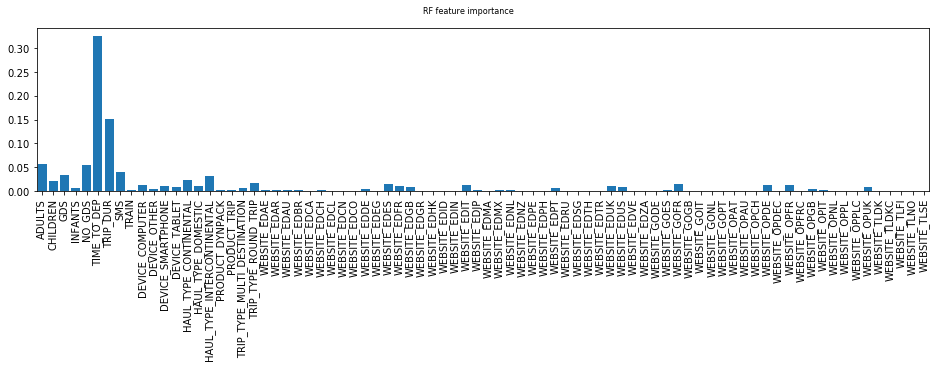

In [23]:
RF_clf = RandomForestClassifier(n_estimators=100)
RFscores = cross_val_score(RF_clf, eval_samples_under, eval_labels_under, cv=10, scoring='f1_weighted')
RF_clf.fit(eval_samples_train_under, eval_labels_train_under)
RF_predicted = RF_clf.predict(eval_samples_test_under)
print('RF 10CV f1_weighted scores : ' + str(RFscores))
print('RF classification report :\n' + str(classification_report(eval_labels_test_under, RF_predicted)))
print('RF confusion matrix :\n' + str(confusion_matrix(eval_labels_test_under, RF_predicted)))

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
fig.suptitle('RF feature importance', fontsize=8)
ax.bar(range(len(RF_clf.feature_importances_)), RF_clf.feature_importances_)
ax.set_xticks(np.arange(0, len(RF_clf.feature_importances_), step=1))
ax.set_xticklabels(dataset_under_transformed.drop(columns=['EXTRA_BAGGAGE']).columns.values,rotation='vertical')
ax.set_xlim([-0.5,len(RF_clf.feature_importances_)-0.5]);

### 3.3.2 Over sampled dataset

#### 3.3.2.1 Default parameter values

RF 10CV f1_weighted scores : [0.90477816 0.90313992 0.9067222  0.90985003 0.90533688 0.90609162
 0.90656346 0.90284427 0.89609084 0.89409411]
RF classification report :
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90      3930
         1.0       0.86      0.97      0.91      3883

    accuracy                           0.90      7813
   macro avg       0.91      0.90      0.90      7813
weighted avg       0.91      0.90      0.90      7813

RF confusion matrix :
[[3300  630]
 [ 127 3756]]


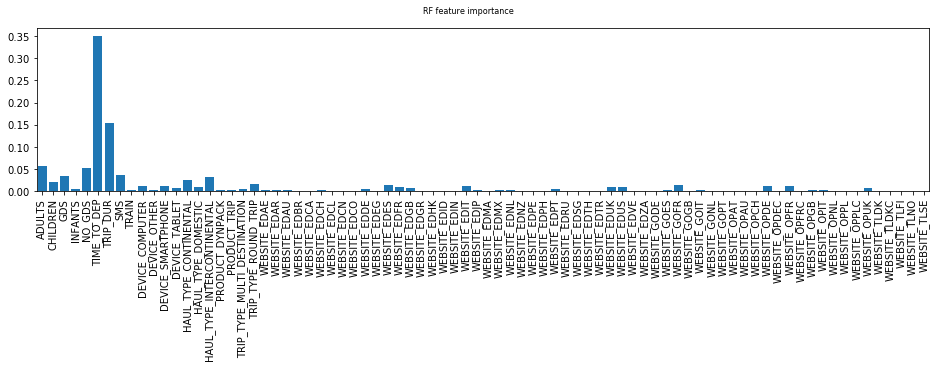

In [24]:
RF_clf = RandomForestClassifier(n_estimators=100)
RFscores = cross_val_score(RF_clf, eval_samples_over, eval_labels_over, cv=10, scoring='f1')
RF_clf.fit(eval_samples_train_over, eval_labels_train_over)
RF_predicted = RF_clf.predict(eval_samples_test_over)
print('RF 10CV f1_weighted scores : ' + str(RFscores))
print('RF classification report :\n' + str(classification_report(eval_labels_test_over, RF_predicted)))
print('RF confusion matrix :\n' + str(confusion_matrix(eval_labels_test_over, RF_predicted)))

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
fig.suptitle('RF feature importance', fontsize=8)
ax.bar(range(len(RF_clf.feature_importances_)), RF_clf.feature_importances_)
ax.set_xticks(np.arange(0, len(RF_clf.feature_importances_), step=1))
ax.set_xticklabels(dataset_over_transformed.drop(columns=['EXTRA_BAGGAGE']).columns.values,rotation='vertical')
ax.set_xlim([-0.5,len(RF_clf.feature_importances_)-0.5]);

#### 3.3.2.2 GridSearchCV for better parameter values

In [78]:
param_grid = [{'n_estimators': [100, 200, 500],
               'max_features': ['auto', 'log2'],
               'max_depth' : [5,10,50,100,None],
               'criterion' :['gini', 'entropy']}]

RF_clf_gs = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100), param_grid=param_grid, scoring='f1',n_jobs=4, cv=10)
RF_clf_gs.fit(eval_samples_train_over, eval_labels_train_over)
means = RF_clf_gs.cv_results_['mean_test_score']
stds = RF_clf_gs.cv_results_['std_test_score']
print('RF 10CV f1 score mean with 95% confidence interval : ')
for mean, std, params in zip(means, stds, RF_clf_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

/home/big-dama/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RF 10CV f1 score mean with 95% confidence interval : 
0.673 (+/-0.012) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
0.675 (+/-0.012) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
0.675 (+/-0.010) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
0.671 (+/-0.010) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
0.673 (+/-0.011) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
0.672 (+/-0.011) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}
0.712 (+/-0.009) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
0.712 (+/-0.009) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
0.714 (+/-0.010) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}
0.704 (

## 3.4 XGBOOST

### 3.4.1 Under sampled dataset

XGBOOST 10CV f1 scores : [0.6889332  0.68588469 0.705      0.68265867 0.70235756 0.70716049
 0.70536153 0.70267592 0.72986248 0.726647  ]
XGBOOST classification report :
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68       944
         1.0       0.69      0.72      0.70       979

    accuracy                           0.69      1923
   macro avg       0.69      0.69      0.69      1923
weighted avg       0.69      0.69      0.69      1923

XGBOOST confusion matrix :
[[625 319]
 [275 704]]


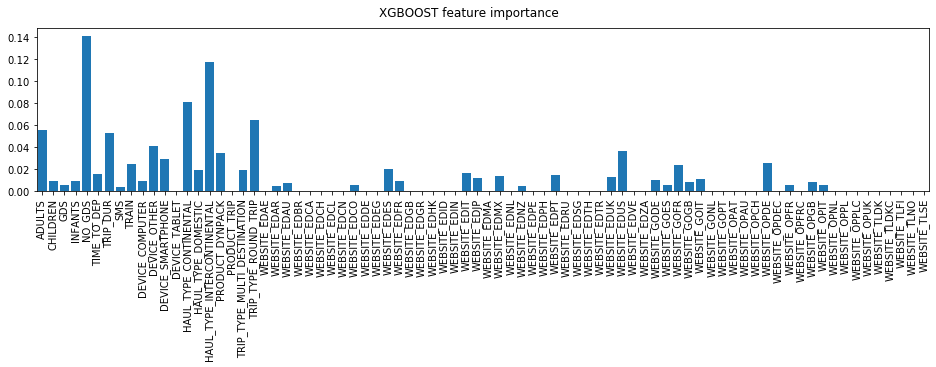

In [25]:
XGBOOST_clf = xgboost.XGBClassifier()
XGBOOSTscores = cross_val_score(XGBOOST_clf, eval_samples_under, eval_labels_under, cv=10, scoring='f1')
XGBOOST_clf.fit( eval_samples_train_under, eval_labels_train_under)
XGBOOST_predicted = XGBOOST_clf.predict(eval_samples_test_under)
print('XGBOOST 10CV f1 scores : ' + str(XGBOOSTscores))
print('XGBOOST classification report :\n' + str(classification_report(eval_labels_test_under, XGBOOST_predicted)))
print('XGBOOST confusion matrix :\n' + str(confusion_matrix(eval_labels_test_under, XGBOOST_predicted)))

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
fig.suptitle('XGBOOST feature importance', fontsize=12)
ax.bar(range(len(XGBOOST_clf.feature_importances_)), XGBOOST_clf.feature_importances_)
ax.set_xticks(np.arange(0, len(XGBOOST_clf.feature_importances_), step=1))
ax.set_xticklabels(dataset_under_transformed.drop(columns=['EXTRA_BAGGAGE']).columns.values,rotation='vertical')
ax.set_xlim([-0.5,len(XGBOOST_clf.feature_importances_)-0.5]);

### 3.4.2.Over sampled dataset

XGBOOST 10CV f1 scores : [0.71079801 0.70669915 0.70533868 0.70421144 0.70494808 0.69375693
 0.70181863 0.70398436 0.71442401 0.70855615]
XGBOOST classification report :
              precision    recall  f1-score   support

         0.0       0.71      0.64      0.68      3930
         1.0       0.67      0.74      0.70      3883

    accuracy                           0.69      7813
   macro avg       0.69      0.69      0.69      7813
weighted avg       0.69      0.69      0.69      7813

XGBOOST confusion matrix :
[[2529 1401]
 [1021 2862]]


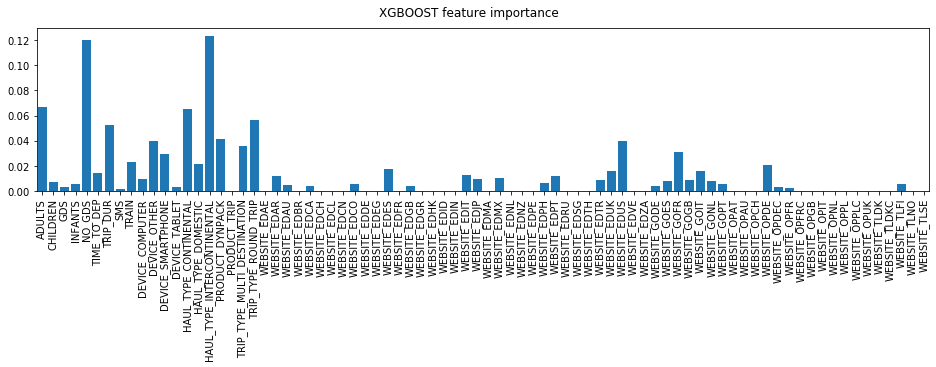

In [26]:
XGBOOST_clf = xgboost.XGBClassifier()
XGBOOSTscores = cross_val_score(XGBOOST_clf, eval_samples_over, eval_labels_over, cv=10, scoring='f1')
XGBOOST_clf.fit( eval_samples_train_over, eval_labels_train_over)
XGBOOST_predicted = XGBOOST_clf.predict(eval_samples_test_over)
print('XGBOOST 10CV f1 scores : ' + str(XGBOOSTscores))
print('XGBOOST classification report :\n' + str(classification_report(eval_labels_test_over, XGBOOST_predicted)))
print('XGBOOST confusion matrix :\n' + str(confusion_matrix(eval_labels_test_over, XGBOOST_predicted)))

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
fig.suptitle('XGBOOST feature importance', fontsize=12)
ax.bar(range(len(XGBOOST_clf.feature_importances_)), XGBOOST_clf.feature_importances_)
ax.set_xticks(np.arange(0, len(XGBOOST_clf.feature_importances_), step=1))
ax.set_xticklabels(dataset_over_transformed.drop(columns=['EXTRA_BAGGAGE']).columns.values,rotation='vertical')
ax.set_xlim([-0.5,len(XGBOOST_clf.feature_importances_)-0.5]);

# 4 Result for test dataset

In [70]:
eval_samples = dataset_over_transformed[~dataset_over_transformed['EXTRA_BAGGAGE'].isnull()].drop(columns=['EXTRA_BAGGAGE']).values
eval_labels = dataset_over_transformed[~dataset_over_transformed['EXTRA_BAGGAGE'].isnull()]['EXTRA_BAGGAGE'].values
eval_test = dataset_over_transformed[dataset_over_transformed['EXTRA_BAGGAGE'].isnull()].drop(columns=['EXTRA_BAGGAGE']).values

RF_clf_res = RandomForestClassifier(n_estimators=100)
RF_clf_res.fit(eval_samples, eval_labels)
RF_clf_res_predicted = RF_clf_res.predict(eval_test)
RF_clf_res_predicted = pd.DataFrame(data=RF_clf_res_predicted, dtype=bool,columns=['EXTRA_BAGGAGE'])
RF_clf_res_predicted.to_csv('results.csv', index=False)
RF_clf_res_predicted.head()

,EXTRA_BAGGAGE
0,False
1,False
2,False
3,False
4,False


# 5 APPENDIX
* next steps

## 5.1 Sampling strategies
* https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
* evaluation of more sophisticated sampling strategies from imbalanced-learn (https://github.com/scikit-learn-contrib/imbalanced-learn/) 

## 5.2 Feature selection
* application and evaluation of feautre selection algorithms http://featureselection.asu.edu/